In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Tue Jan 16 18:32:06 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   30C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.normal_prior import Prior
from model.latent.mmd_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]
hp.opts = {'pz_scale': 1,
           'mmd_kernel': 'IMQ', # 'IMQ', 'RBF'
            'pz': 'normal', # 'normal', 'sphere', 'uniform'
            'zdim': hp.z_dim
           }

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.16-3/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 371400
-rw-rw-r-- 1 scpark scpark     30212  1월 16 18:32 events.out.tfevents.1705397386.GPUSVR11
-rw-rw-r-- 1 scpark scpark 380279199  1월 16 18:30 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


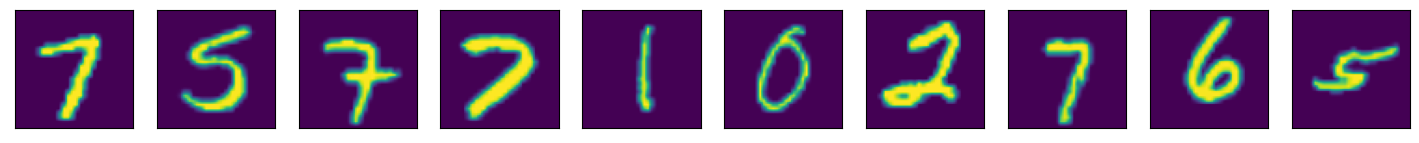

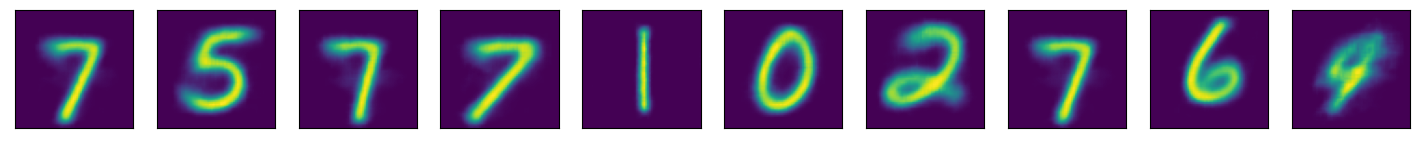

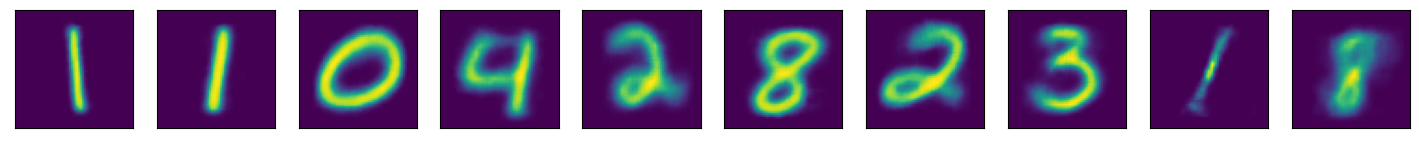

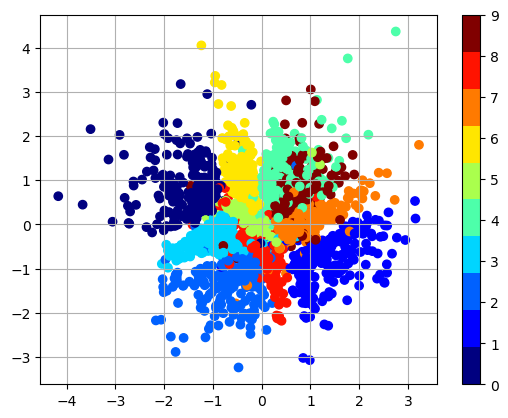

10001
mmd_loss -0.002820083498954773
recon_loss 0.1158161960542202
10002
mmd_loss -0.0008433580398559571
recon_loss 0.11322075203061104
10003
mmd_loss -0.0031347274780273438
recon_loss 0.11165493428707123
10004
mmd_loss -0.0005321383476257324
recon_loss 0.11608579829335212
10005
mmd_loss -0.004429775476455689
recon_loss 0.11168603301048279
10006
mmd_loss -0.0007938891649246216
recon_loss 0.11012970209121704
10007
mmd_loss 0.002017483115196228
recon_loss 0.11332025900483131
10008
mmd_loss -0.0053545147180557254
recon_loss 0.10930372178554534
10009
mmd_loss 0.0045774787664413456
recon_loss 0.11204812899231911
10010
mmd_loss -0.006289380788803101
recon_loss 0.11153737381100655
10011
mmd_loss -0.0019898772239685058
recon_loss 0.11010031476616859
10012
mmd_loss -0.003717401623725891
recon_loss 0.11452333629131317
10013
mmd_loss -0.0041774451732635495
recon_loss 0.11083931401371956
10014
mmd_loss -0.0006017476320266723
recon_loss 0.11416809186339379
10015
mmd_loss -0.0040483266115188595
reco

mmd_loss -0.0022039830684661863
recon_loss 0.11554601266980172
10123
mmd_loss -0.004189398884773254
recon_loss 0.10634498447179794
10124
mmd_loss -0.004033169150352478
recon_loss 0.11012548133730889
10125
mmd_loss 0.010094362497329711
recon_loss 0.11094345897436142
10126
mmd_loss -0.003009071946144104
recon_loss 0.11113382577896118
10127
mmd_loss -0.00212969183921814
recon_loss 0.1115327849984169
10128
mmd_loss 0.002169615030288696
recon_loss 0.10622532218694687
10129
mmd_loss -0.004355156421661377
recon_loss 0.11158363074064255
10130
mmd_loss -0.0014719337224960328
recon_loss 0.11004216000437736
10131
mmd_loss -0.0011309951543807984
recon_loss 0.11218215599656105
10132
mmd_loss -0.004039004445075989
recon_loss 0.11393619254231453
10133
mmd_loss 0.0023452699184417724
recon_loss 0.1119830846786499
10134
mmd_loss -0.008648616075515748
recon_loss 0.11483162268996239
10135
mmd_loss -0.003744649887084961
recon_loss 0.11525074392557144
10136
mmd_loss -0.0024827450513839723
recon_loss 0.11813

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        